In [279]:
import pandas as pd
from pandas.api.types import is_string_dtype
import numpy as np
import re
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.options.display.max_colwidth = 1000

In [280]:
#Functions
def column_name_cleaning(table):
    table_copy = table.copy()
    table_copy.columns = table_copy.columns.str.lower()
    table_copy.columns = [re.sub('(,)|(:)|(-)', '', x) for x in table_copy.columns]
    table_copy.columns = [re.sub('(_)', ' ', x) for x in table_copy.columns]
    table_copy.columns = [x.strip(' ') for x in table_copy.columns]
    
    # patient id column name normalization
    if 'subject number' in table_copy.columns: 
        table_copy = table_copy.rename(mapper={'subject number': 'patient id'}, axis=1)
    elif 'patient id' in table_copy.columns: 
        table_copy = table_copy.rename(mapper={'patient id': 'patient id'}, axis=1)
    return table_copy


def str_column_cleaning(table):
    table_copy = table.copy()
    for col in table_copy.columns:
        if table_copy[col].dtype == object:
            table_copy[col] = table_copy[col].str.lower()
            table_copy[col] = table_copy[col].str.replace('(,)|(:)|(-)', '', regex=True)
            table_copy[col] = table_copy[col].str.replace('(_)', ' ',regex=True)
            table_copy[col] = table_copy[col].str.strip(' ')
    return table_copy


def get_unique_value_col(table, string=False):
    '''
    table: pandas dataframe
    string: computes unique value only for columns containing string
    ''' 
    unique_value = []
    unique_value_str = set()
    for col in table.columns:
        unique_value.append(list(pd.unique(table[col])))
        if string and col != 'patient id':
            unique_value_str.update(set(pd.unique(table[col])))
    
    if string: 
        #even when the column dtype is str, some values are not string
        unique_value_str_clean = unique_value_str.copy()
        for el in unique_value_str:
            if not(isinstance(el, str)):
                unique_value_str_clean.remove(el)
        return(unique_value_str_clean)
    
    return pd.DataFrame({"unique_value": unique_value}, index=table.columns)     


def check_merging(table1, table2, merged, columns_merged):  
    for col in columns_merged:
        NA_table1 = table1[col].isna().sum()
        NA_table2 = table2[col].isna().sum()
        NA_merged = merged[col].isna().sum()
        if not(np.equal((NA_table1 + NA_table2),NA_merged)):
            return print(f"error in {col}")
    if not((table1.shape[0]+table2.shape[0]) == merged.shape[0]):
        return print(f'error in na counts')
    return print('ok')

def get_plot_na(table, axis):
    na_count = table.isna().sum(axis=axis).sort_values(ascending=False)
    if axis==0:
        labels={'index': 'features', 'value':'missing value count'}
        fig = px.bar(na_count, height=600, width=2000, labels=labels)

    else:
        labels={'index': 'number of missing value', 'value':'number of patients'}
        fig = px.bar(na_count.value_counts().sort_index(), height=600, width=2000, labels=labels)

    fig.update_layout(font_size=8, bargap=0.3)
    return fig

# Constant
YES_REPLACEMENT = 'yes'
NO_REPLACEMENT = 'no'

# Loading

In [281]:
filepath_stroke = "../data/cerebral_elderly_stroke/subjects.csv"
filepath_perfusion = '../data/cerebral_perfusion_data/data_description/GE-75_data_summary_table.csv'
filepath_diabetes = '../data/cerebral_elderly_diabetes/Data_Description/GE-79_Summary_Table-Demographics-MRI-Part1.csv'
filepath_desc = '../data/cerebral_perfusion_data/data_description/GE-75_data_dictionary.csv'
df_stroke = pd.read_csv(filepath_stroke)
df_perfusion = pd.read_csv(filepath_perfusion, header=0)
df_diabetes = pd.read_csv(filepath_diabetes)
df_desc = pd.read_csv(filepath_desc, usecols=range(5))

In [282]:
df_stroke.head()

,subject_number,completed_visit_status,htn_patient_medical_history,group,group2,age,height/m,mass/kg,bmi,gender,ethnicity,race,DM Non-DM STROKE,previous_tobacco_use,current_tobacco_use,pack_years,years,PREVIOUS ALCOHOL USE,ALCOHOL Dose/Week,Neuropathy AUTONOMIC SYMPTOMS,Dizziness AUTONOMIC SYMPTOMS,Numbness AUTONOMIC SYMPTOMS,Painful feet AUTONOMIC SYMPTOMS,Syncope AUTONOMIC SYMPTOMS,OH AUTONOMIC SYMPTOMS,"cancer,# FAMILY HISTORY",cancSpec FAMILY HISTORY,HeartDisease FAMILY HISTORY,Hdspecific FAMILY HISTORY,HTN FAMILY HISTORY,HTNspecific FAMILY HISTORY,DM FAMILY HISTORY,Dmspecific FAMILY HISTORY,StrokeFAMILY HISTORY,StrokeSpecific FAMILY HISTORY,HTN YRS PATIENT MEDICAL HISTORY,CANCER PATIENT MEDICAL HISTORY,STROKE PATIENT MEDICAL HISTORY,STROKE YR PATIENT MEDICAL HISTORY,ATRIAL FIBTRILLATION PATIENT MEDICAL HISTORY,HEART FAILURE =CHF /IFARCTION=-MI PATIENT MEDICAL HISTORY,HYPERLIPIDEMIA PATIENT MEDICAL HISTORY,DM PATIENT MEDICAL HISTORY,Stroke Date,NIHSS,MRS,Stroke Group,Stroke Side,Stroke Etiology,Symptoms,Lesions,Carotids,Tapered Medications taken during Visit 2,ANTIPLATELETS,ANTICOAGULANTS,ANTIHYPERLIPIDEMIC,ANTIPARKINSONIAN,STATINS,ESTROGEN,ACE INHIBITORS,ARBS,BETA BLOCKERS,DIURETICS,CA ++ BLOCKERS,INSULIN(Yes_or_No),ORAL HYPOGLYCEMIC,MRI YES OR NO,WBC K/uL,RBC m/uL,Hgb g/dL,Hgb<12.5,Hct %,MCV fL,MCH pg,MCHC %,RDW%,Plt ct K/uL,GLUCOSE mg/dL,CHOLESTmg/dL,TRIGLYCmg/dL,HDL mg/dL,CHOL/HD Ratio,LDL CALCmg/dL,SICAM (ng/ml),SVCAM (ng/ml),CRP (mg/L),IL-6 (pg/ml),TNFa (pg/ml),Erythropoietin(EPO),lnEPO,(Baseline Mean) HR BP BASELINE,SBP BASELINE,DBP BASELINE,MBP,SYST MCAR BASELINE,DIAST MCAR BASELINE,MEAN MCAR BASELINE,SYST MCAL BASELINE,DIAST MCAL BASELINE,MEAN MCAL BASELINE,SYST RA BASELINE,DIAST RA BASELINE,MEAN RA BASELINE,CO2 BASELINE,(Tilt mn) HR TILT,SBP TILT,DBP TILT,MBP TILT,SYST MCAR TILT,DIAST MCAR TILT,MEAN MCAR TILT,SYST MCAL TILT,DIAST MCAL TILT,MEAN MCAL TILT,SYSRA TILT,DIA RA TILT,MEAN RA TILT,CO2 TILT,(Hyper mn) HR HYPERVENTILATION,SBP HV,DBP HV,MBP HV,SYST MCAR HV,DIAST MCAR HV,MEAN MCAR HV,SYST MCAL HV,DIAST MCAL HV,MEAN MCAL HV,SYSRA HV,DIA RA HV,MEAN RA HV,CO2 HV,(Hypo mn) HR SUPINE REBREATHING,SBP SUPINE REBREATHING,DBP SUPINE REBREATHING,MBP SUPINE REBREATHING,SYST MCAR SUPINE REBREATHING,DIAST MCAR SUPINE REBREATHING,MEAN MCAR SUPINE REBREATHING,SYST MCAL SUPINE REBREATHING,DIAST MCAL SUPINE REBREATHING,MEAN MCAL SUPINE REBREATHING,SYSRA SUPINE REBREATHING,DIA RA SUPINE REBREATHING,MEAN RA SUPINE REBREATHING,CO2 SUPINE REBREATHING,(SitEO mn) SitEO HR mean,Systolic BP SitEO,Diastolic BP SitEO,Mean BP SitEO,Sys MCAR SitEO,DIa MCAR SitEO,Mean MCAR SitEO,Sys MCAL SitEO,Dia MCAL SitEO,Mean MCAL SitEO,Sys RAAR SitEO,Dia RAAR SitEO,Mean RAAR SitEO,ETCO2 SitEO,(StandEO mn) Mean HR StandEO,Sys BP StandEO,Dia BP StandEO,Mean BP StandEO,Sys MCAR StandEO,Dia MCAR StandEO,Mean MCAR StandEO,Sys MCAL StandEO,Dia MCAL StandEO,Mean MCAL StandEO,Sys RAAR StandEO,Dia RAAR StandEO,Mean RAAR StandEO,ETCO2 StandEO,(SitEC mn) Mean HR SitEC,Sys BP SitEC,Dia BP SitEC,Mean BP SitEC,Sys MCAR SitEC,Dia MCAR SitEC,Mean MCAR SitEC,Sys MCAL SitEC,Dia MCAL SitEC,Mean MCAL SitEC,Sys RAAR SitEC,Dia RAAR SitEC,Mean RAAR SitEC,ETCO2 SitEC,(StandEC mn) Mean HR StandEC,Sys BP StandEC,Dia BP StandEC,Mean BP StandEC,Sys MCAR StandEC,Dia MCAR StandEC,Mean MCAR StandEC,Sys MCAL StandEC,DIa MCAL StandEC,Mean MCAL StandEC,Sys RAAR StandEC,Dia RAAR StandEC,Mean RAAR StandEC,ETCO2 StandEC,Age_Residual MEAN MCAR BASELINE,Age_Residual MEAN MCAL BASELINE,Age_adjusted_Mean_MCAR_BASELINE,Age_adjusted_Mean_MCAL_BASELINE,Age_adjusted_Mean_MCARL_BASELINE,CO2_reactivity_MCAR,CO2_reactivity_MCAL,DELTA MEAN MCAR TILT-BASELINE,DELTA MEAN MCAL TILT-BASELINE,DELTA MEAN BP TILT-BASELINE,# Falls within last year,Falls-related injuries,24Hour-Daytime-SBP,24Hour-Nighttime-SBP,24Hour-Daytime-DBP,24Hour-Nighttime-DBP,24Hour-Daytime-MBP,24Hour-Nightime-MBP,24Hour-Daytime-HR,24Hour-Nightime-HR,24Hour-Daytime-PP,24Hour-Nightime-PP,24Hour-SBPDIP,24Hour-SBPDIP%,24Hour-DBPDIP,24H

In [283]:
df_diabetes.head()

,Patient ID,study,Visit,Group,Diabetes Duration,HTN or not,Race,"DM, Non-DM, STROKE",HEIGHT (M),MASS (KG),BMI,global GM vol,global GM vol covered in template,L superior frontal gyrus (#21) GM,R superior frontal gyrus (#22) GM,L middle frontal gyrus (#23) GM,R middle frontal gyrus (#24) GM,L inferior frontal gyrus (#25) GM,R inferior frontal gyrus (#26) GM,L precentral gyrus (#27) GM,R precentral gyrus (#28) GM,L middle orbitofrontal gyrus (#29) GM,R middle orbitofrontal gyrus (#30) GM,L lateral orbitofrontal gyrus (#31) GM,R lateral orbitofrontal gyrus (#32) GM,L gyrus rectus (#33) GM,R gyrus rectus (#34) GM,L postcentral gyrus (#41) GM,R postcentral gyrus (#42) GM,L superior parietal gyrus (#43) GM,R superior parietal gyrus (#44) GM,L supramarginal gyrus (#45) GM,R supramarginal gyurs (#46) GM,L angular gyrus (#47) GM,R angular gyrus (#48) GM,L precuneus (#49) GM,R precuneus (#50) GM,L superior occipital gyrus (#61) GM,R superior occipital gyrus (#62) GM,L middle occipital gyrus (#63) GM,R middle occipital gyrus (#64) GM,L inferior occipital gyrus (#65) GM,R inferior occipital gyrus (#66) GM,L cuneus (#67) GM,R cuneus (#68) GM,L superior temporal gyrus (#81) GM,R superior temporal gyrus (#82) GM,L middle temporal gyrus (#83) GM,R middle temporal gyrus (#84) GM,L inferior temporal gyrus (#85) GM,R inferior temporal gyrus (#86) GM,L parahippocampal gyrus (#87) GM,R parahippocampal gyrus (#88) GM,L lingual gyrus (#89) GM,R lingual gyrus (#90) GM,L fusiform gyrus (#91) GM,R fusiform gyrus (#92) GM,L insular cortex (#101) GM,R insular cortex (#102) GM,L cingulate gyrus (#121) GM,R cingulate gyrus (#122) GM,L caudate (#161) GM,R caudate (#162) GM,L putamen (#163) GM,R putamen (#164) GM,L hippocampus (#165) GM,R hippocampus (#166) GM,cerebellum (#181) GM,brain stem (#182) GM,global WM vol,global WM vol covered in template,L superior frontal gyrus (#21) WM,R superior frontal gyrus (#22) WM,L middle frontal gyrus (#23) WM,R middle frontal gyrus (#24) WM,L inferior frontal gyrus (#25) WM,R inferior frontal gyrus (#26) WM,L precentral gyrus (#27) WM,R precentral gyrus (#28) WM,L middle orbitofrontal gyrus (#29) WM,R middle orbitofrontal gyrus (#30) WM,L lateral orbitofrontal gyrus (#31) WM,R lateral orbitofrontal gyrus (#32) WM,L gyrus rectus (#33) WM,R gyrus rectus (#34) WM,L postcentral gyrus (#41) WM,R postcentral gyrus (#42) WM,L superior parietal gyrus (#43) WM,R superior parietal gyrus (#44) WM,L supramarginal gyrus (#45) WM,R supramarginal gyurs (#46) WM,L angular gyrus (#47) WM,R angular gyrus (#48) WM,L precuneus (#49) WM,R precuneus (#50) WM,L superior occipital gyrus (#61) WM,R superior occipital gyrus (#62) WM,L middle occipital gyrus (#63) WM,R middle occipital gyrus (#64) WM,L inferior occipital gyrus (#65) WM,R inferior occipital gyrus (#66) WM,L cuneus (#67) WM,R cuneus (#68) WM,L superior temporal gyrus (#81) WM,R superior temporal gyrus (#82) WM,L middle temporal gyrus (#83) WM,R middle temporal gyrus (#84) WM,L inferior temporal gyrus (#85) WM,R inferior temporal gyrus (#86) WM,L parahippocampal gyrus (#87) WM,R parahippocampal gyrus (#88) WM,L lingual gyrus (#89) WM,R lingual gyrus (#90) WM,L fusiform gyrus (#91) WM,R fusiform gyrus (#92) WM,L insular cortex (#101) WM,R insular cortex (#102) WM,L cingulate gyrus (#121) WM,R cingulate gyrus (#122) WM,L caudate (#161) WM,R caudate (#162) WM,L putamen (#163) WM,R putamen (#164) WM,L hippocampus (#165) WM,R hippocampus (#166) WM,cerebellum (#181) WM,brain stem (#182) WM,global CSF vol,global CSF vol covered in template,L superior frontal gyrus (#21) CSF,R superior frontal gyrus (#22) CSF,L middle frontal gyrus (#23) CSF,R middle frontal gyrus (#24) CSF,L inferior frontal gyrus (#25) CSF,R inferior frontal gyrus (#26) CSF,L precentral gyrus (#27) CSF,R precentral gyrus (#28) CSF,L middle orbitofrontal gyrus (#29) CSF,R middle orbitofrontal gyrus (#30) CSF,L lateral orbitofrontal gyrus (#31) CSF,R lateral orbitofrontal gyrus (#32) CSF,L gyrus rectus (#33) CSF,R gyrus rectu

In [284]:
df_perfusion.head()

,patient ID,study,Group,template,Diabetes Duration,HTN or not,HTN2,age,sex,Gender,HEIGHT (M),MASS (KG),BMI,global GM vol,global GM vol covered in template,L superior frontal gyrus (#21) GM,R superior frontal gyrus (#22) GM,L middle frontal gyrus (#23) GM,R middle frontal gyrus (#24) GM,L inferior frontal gyrus (#25) GM,R inferior frontal gyrus (#26) GM,L precentral gyrus (#27) GM,R precentral gyrus (#28) GM,L middle orbitofrontal gyrus (#29) GM,R middle orbitofrontal gyrus (#30) GM,L lateral orbitofrontal gyrus (#31) GM,R lateral orbitofrontal gyrus (#32) GM,L gyrus rectus (#33) GM,R gyrus rectus (#34) GM,L postcentral gyrus (#41) GM,R postcentral gyrus (#42) GM,L superior parietal gyrus (#43) GM,R superior parietal gyrus (#44) GM,L supramarginal gyrus (#45) GM,R supramarginal gyurs (#46) GM,L angular gyrus (#47) GM,R angular gyrus (#48) GM,L precuneus (#49) GM,R precuneus (#50) GM,L superior occipital gyrus (#61) GM,R superior occipital gyrus (#62) GM,L middle occipital gyrus (#63) GM,R middle occipital gyrus (#64) GM,L inferior occipital gyrus (#65) GM,R inferior occipital gyrus (#66) GM,L cuneus (#67) GM,R cuneus (#68) GM,L superior temporal gyrus (#81) GM,R superior temporal gyrus (#82) GM,L middle temporal gyrus (#83) GM,R middle temporal gyrus (#84) GM,L inferior temporal gyrus (#85) GM,R inferior temporal gyrus (#86) GM,L parahippocampal gyrus (#87) GM,R parahippocampal gyrus (#88) GM,L lingual gyrus (#89) GM,R lingual gyrus (#90) GM,L fusiform gyrus (#91) GM,R fusiform gyrus (#92) GM,L insular cortex (#101) GM,R insular cortex (#102) GM,L cingulate gyrus (#121) GM,R cingulate gyrus (#122) GM,L caudate (#161) GM,R caudate (#162) GM,L putamen (#163) GM,R putamen (#164) GM,L hippocampus (#165) GM,R hippocampus (#166) GM,cerebellum (#181) GM,brain stem (#182) GM,global WM vol,global WM vol covered in template,L superior frontal gyrus (#21) WM,R superior frontal gyrus (#22) WM,L middle frontal gyrus (#23) WM,R middle frontal gyrus (#24) WM,L inferior frontal gyrus (#25) WM,R inferior frontal gyrus (#26) WM,L precentral gyrus (#27) WM,R precentral gyrus (#28) WM,L middle orbitofrontal gyrus (#29) WM,R middle orbitofrontal gyrus (#30) WM,L lateral orbitofrontal gyrus (#31) WM,R lateral orbitofrontal gyrus (#32) WM,L gyrus rectus (#33) WM,R gyrus rectus (#34) WM,L postcentral gyrus (#41) WM,R postcentral gyrus (#42) WM,L superior parietal gyrus (#43) WM,R superior parietal gyrus (#44) WM,L supramarginal gyrus (#45) WM,R supramarginal gyurs (#46) WM,L angular gyrus (#47) WM,R angular gyrus (#48) WM,L precuneus (#49) WM,R precuneus (#50) WM,L superior occipital gyrus (#61) WM,R superior occipital gyrus (#62) WM,L middle occipital gyrus (#63) WM,R middle occipital gyrus (#64) WM,L inferior occipital gyrus (#65) WM,R inferior occipital gyrus (#66) WM,L cuneus (#67) WM,R cuneus (#68) WM,L superior temporal gyrus (#81) WM,R superior temporal gyrus (#82) WM,L middle temporal gyrus (#83) WM,R middle temporal gyrus (#84) WM,L inferior temporal gyrus (#85) WM,R inferior temporal gyrus (#86) WM,L parahippocampal gyrus (#87) WM,R parahippocampal gyrus (#88) WM,L lingual gyrus (#89) WM,R lingual gyrus (#90) WM,L fusiform gyrus (#91) WM,R fusiform gyrus (#92) WM,L insular cortex (#101) WM,R insular cortex (#102) WM,L cingulate gyrus (#121) WM,R cingulate gyrus (#122) WM,L caudate (#161) WM,R caudate (#162) WM,L putamen (#163) WM,R putamen (#164) WM,L hippocampus (#165) WM,R hippocampus (#166) WM,cerebellum (#181) WM,brain stem (#182) WM,global CSF vol,global CSF vol covered in template,L superior frontal gyrus (#21) CSF,R superior frontal gyrus (#22) CSF,L middle frontal gyrus (#23) CSF,R middle frontal gyrus (#24) CSF,L inferior frontal gyrus (#25) CSF,R inferior frontal gyrus (#26) CSF,L precentral gyrus (#27) CSF,R precentral gyrus (#28) CSF,L middle orbitofrontal gyrus (#29) CSF,R middle orbitofrontal gyrus (#30) CSF,L lateral orbitofrontal gyrus (#31) CSF,R lateral orbitofrontal gyrus (#32) CSF,L gyrus rectus (#33) CSF,R gyrus rectus (

# Exploration

Let's check if there are common patients between the datasets

In [285]:
set_diabetes = set(df_diabetes["Patient ID"].str.lower())
set_perfusion = set(df_perfusion["patient ID"].str.lower())
set_stroke = set(df_stroke["subject_number"].str.lower())

In [286]:
# Common elements
print(f'all three {len(set_diabetes & set_perfusion & set_stroke)}')
print(f'perfusion - diabetes {len(set_diabetes & set_perfusion)}')
print(f'perfusion - stroke {len(set_perfusion & set_stroke)}')
print(f'diabetes - stroke {len(set_diabetes & set_stroke)}')

all three 0
perfusion - diabetes 11
perfusion - stroke 1
diabetes - stroke 14


In [287]:
# Elements in
print(f'diabetes in stroke {(df_diabetes["Patient ID"].str.lower()).isin(set_stroke).sum()}')
print(f'diabetes in perfusion {(df_diabetes["Patient ID"].str.lower()).isin(set_perfusion).sum()}')

print(f'stroke in diabetes {(df_stroke["subject_number"].str.lower()).isin(set_diabetes).sum()}')
print(f'stroke in perfusion {(df_stroke["subject_number"].str.lower()).isin(set_perfusion).sum()}')

print(f'perfusion in diabetes {(df_perfusion["patient ID"].str.lower()).isin(set_diabetes).sum()}')
print(f'perfusion in stroke {(df_perfusion["patient ID"].str.lower()).isin(set_stroke).sum()}')

diabetes in stroke 24
diabetes in perfusion 18
stroke in diabetes 14
stroke in perfusion 1
perfusion in diabetes 11
perfusion in stroke 1


The diabetes dataset is missing important features (age, gender, ...).
Plus, stroke and perfusion datasets present in addition of the all the required demographic features, medical records and some lifestyle features: alcohol and tabacco use. 

Let's check the common patient of perfusion and stroke dataset

In [288]:
common_patient = set_perfusion & set_stroke

In [289]:
df_perfusion_homogenized = str_column_cleaning(df_perfusion)
df_perfusion_homogenized = column_name_cleaning(df_perfusion_homogenized)

df_stroke_homogenized =  str_column_cleaning(df_stroke)
df_stroke_homogenized = column_name_cleaning(df_stroke_homogenized)

print(df_perfusion_homogenized[df_perfusion_homogenized["patient id"].isin(common_patient)].isna().sum(axis=1)/df_perfusion_homogenized.shape[1])
print(df_stroke_homogenized[df_stroke_homogenized["patient id"].isin(common_patient)].isna().sum(axis=1)/df_stroke_homogenized.shape[1])

67    0.955896
dtype: float64
166    0.889391
dtype: float64


This patient has a lot of missing value and would be removed from the dataset

# Stroke & Perfusion datasets

## Loading v1

Stroke and perfusion datasets have been pre-filtered in different notebooks

In [290]:
filepath_stroke_v1 = "../data/cerebral_elderly_stroke/exploration/cerebral_elderly_stroke_v1.csv"
filepath_perfusion_v1 = "../data/cerebral_perfusion_data/exploration/cerebral_perfusion_diabetes_v1.csv"
df_stroke_v1 = pd.read_csv(filepath_stroke_v1)
df_perfusion_v1 = pd.read_csv(filepath_perfusion_v1)

In [291]:
df_stroke_v1.head()

,subject_number,completed_visit_status,htn_patient_medical_history,group,group2,age,height/m,mass/kg,bmi,gender,ethnicity,race,DM Non-DM STROKE,previous_tobacco_use,current_tobacco_use,pack_years,years,PREVIOUS ALCOHOL USE,ALCOHOL Dose/Week,Neuropathy AUTONOMIC SYMPTOMS,Dizziness AUTONOMIC SYMPTOMS,Numbness AUTONOMIC SYMPTOMS,Painful feet AUTONOMIC SYMPTOMS,Syncope AUTONOMIC SYMPTOMS,OH AUTONOMIC SYMPTOMS,"cancer,# FAMILY HISTORY",HeartDisease FAMILY HISTORY,HTN FAMILY HISTORY,DM FAMILY HISTORY,StrokeFAMILY HISTORY,CANCER PATIENT MEDICAL HISTORY,STROKE PATIENT MEDICAL HISTORY,ATRIAL FIBTRILLATION PATIENT MEDICAL HISTORY,HEART FAILURE =CHF /IFARCTION=-MI PATIENT MEDICAL HISTORY,HYPERLIPIDEMIA PATIENT MEDICAL HISTORY,DM PATIENT MEDICAL HISTORY,Stroke Group,ANTIPLATELETS,ANTICOAGULANTS,ANTIHYPERLIPIDEMIC,ANTIPARKINSONIAN,STATINS,ESTROGEN,ACE INHIBITORS,ARBS,BETA BLOCKERS,DIURETICS,CA ++ BLOCKERS,INSULIN(Yes_or_No),ORAL HYPOGLYCEMIC,WBC K/uL,RBC m/uL,Hgb g/dL,Hgb<12.5,Hct %,MCV fL,MCH pg,MCHC %,RDW%,Plt ct K/uL,GLUCOSE mg/dL,CHOLESTmg/dL,TRIGLYCmg/dL,HDL mg/dL,CHOL/HD Ratio,LDL CALCmg/dL,CRP (mg/L)
0,S0011,INELIGIBLE,YES,CONTROL,CONTROL-HTN,70,1.6383,71.667594,26.701519,F,Non-H/L,White,Non-DM,YES,NO,20.0,40.0,YES,0.0,NO,NO,NO,NO,NO,NO,0,1,0,0,0,NO,NO,NO,NO,NO,NO,Non-Stroke,N,N,N,N,N,N,N,Y,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.67
1,S0030,COMPLETED,YES,CONTROL,CONTROL-NTN,64,1.6256,72.574779,27.463655,F,Non-H/L,White,Non-DM,NO,NO,0.0,0.0,YES,0.0,NO,NO,NO,NO,NO,NO,0,0,0,0,0,NO,NO,NO,NO,NO,NO,Non-Stroke,N,N,N,N,N,N,N,N,N,N,N,N,N,5.7,4.65,14.1,Non-anemic,41.7,90.0,30.2,33.8,12.9,252.0,74.0,270.0,242.0,66.0,4.1,156.0,1.99
2,S0033,EXCLUDED,no,CONTROL,CONTROL-NTN,65,1.8200,92.986000,28.072093,M,Non H/L,WHITE,Non-DM,YES,NO,10.0,10.0,yes,1.0,no,NO,NO,NO,NO,NO,0,2,1,1,1,no,no,NO,No,no,no,Non-Stroke,n,n,N,N,N,n,Y,N,N,N,N,N,N,7.2,4.40,14.3,Non-anemic,39.3,89.0,32.5,36.4,14.3,206.0,76.0,160.0,98.0,44.0,3.6,96.0,0.32
3,S0044,COMPLETED,NO,CONTROL,CONTROL-HTN,74,1.7018,68.038855,23.493080,F,Non-H/L,White,Non-DM,YES,NaN,40.0,40.0,YES,2.0,NO,YES,YES,NO,NO,YES,3,0,0,0,0,NO,NO,NO,NO,NO,NO,Non-Stroke,N,N,N,N,N,N,N,N,N,N,N,N,N,6.1,4.54,15.0,Non-anemic,44.0,97.0,33.0,34.1,13.6,242.0,66.0,189.0,139.0,60.0,3.2,101.0,3.70
4,S0064,COMPLETED,YES,CONTROL,CONTROL-NTN,76,1.7018,68.038855,23.493080,M,Non-H/L,White,Non-DM,NO,NO,0.0,0.0,YES,0.0,NO,NO,NO,NO,NO,NO,0,2,0,0,0,NO,NO,NO,NO,YES,NO,Non-Stroke,N,N,N,N,Y,N,N,N,N,N,N,N,N,5.7,4.48,14.9,Non-anemic,43.6,97.0,33.1,34.1,12.3,180.0,75.0,204.0,136.0,44.0,4.6,133.0,1.82


In [292]:
df_perfusion_v1.head()

,patient ID,study,Group,Diabetes Duration,age,sex,HEIGHT (M),MASS (KG),BMI,Ethnicity,"DM, Non-DM, STROKE",PREVIOUS TOBACCO USE,CURRENT TOBACCO USE,PackYears,Years,PREVIOUS ALCOHOL USE,ALCOHOL Dose/Week,Neuropathy AUTONOMIC SYMPTOMS,Dizziness AUTONOMIC SYMPTOMS,Numbness AUTONOMIC SYMPTOMS,Painful feet AUTONOMIC SYMPTOMS,Syncope AUTONOMIC SYMPTOMS,OH AUTONOMIC SYMPTOMS,"cancer,# FAMILY HISTORY",HeartDisease FAMILY HISTORY,HTN FAMILY HISTORY,DM FAMILY HISTORY,Dmspecific FAMILY HISTORY,StrokeFAMILY HISTORY,CANCER PATIENT MEDICAL HISTORY,STROKE PATIENT MEDICAL HISTORY,ATRIAL FIBTRILLATION PATIENT MEDICAL HISTORY,HEART FAILURE =CHF /IFARCTION=-MI PATIENT MEDICAL HISTORY,HYPERLIPIDEMIA PATIENT MEDICAL HISTORY,DM PATIENT MEDICAL HISTORY,Medications,ANTIPLATELETS,ANTICOAGULANTS,ANTIHYPERLIPIDEMIC,ANTIPARKINSONIAN,STATINS,ESTROGEN,ACE INHIBITORS,ARBS,BETA BLOCKERS,DIURETICS,CA ++ BLOCKERS,INSULIN(Yes_or_No),ORAL HYPOGLYCEMIC,OTHER 2,WBC K/uL,Hgb g/dL,Hgb<12.5,Hct %,MCV fL,MCH pg,MCHC %,Plt ct K/uL,GLUCOSE mg/dL,CHOLESTmg/dL,TRIGLYCmg/dL,HDL mg/dL,CHOL/HD Ratio,URINE CREAT mg/dL,URINE ALBUMIN mg/dL,Alb/Cre mg/g (URINE),Hb A1C%,CRP (mg/L)
0,S0250,GE75,DM,7.0,50,Male,1.790,114.65,35.782279,H/L,DM,YES,NO,2.86,10.0,YES,7.0,NO,NO,NO,NO,NO,NO,1,1,1,1,m,0,NO,NO,NO,NO,NO,YES,"glyburide, metformin hydrochloride, multivitamin",N,N,N,N,N,N,N,N,N,N,N,N,Y,multivitamin,6.9,15.0,Non-anemic,42.2,80.0,28.2,35.5,250.0,211.0,135.0,267.0,36.0,4.5,65.0,2.4,3.69,9.4,0.240
1,S0254,GE75,CONTROL,0.0,69,Female,1.531,56.90,24.275148,Non-H/L,Non-DM,YES,NO,0.14,1.0,YES,0.5,NO,NO,NO,NO,YES,NO,1,1,1,0,NaN,1,NO,NO,NO,NO,NO,NO,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,NaN,6.7,14.2,Non-anemic,39.1,87.0,31.7,36.5,242.0,95.0,176.0,95.0,59.0,3.0,137.0,8.0,58.40,5.1,0.104
2,S0255,GE75,DM,3.0,78,Female,1.520,65.77,28.466932,Non-H/L,DM,NO,No,0.00,0.0,Yes,9.0,No,No,No,NO,NO,NO,0,3,0,3,"f,b,si",0,No,No,NO,NO,YES,YES,"Ranatidine, Zocor, Inderal, Calcuim + Vitamin D, Metamucil",N,N,N,N,Y,N,N,N,Y,N,N,N,N,"Ranitidine, Calcium + D, Metamucil",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S0256,GE75,DM,23.0,65,Female,1.575,73.50,29.629630,Non-H/L,DM,YES,NO,5.71,20.0,YES,3.0,NO,NO,NO,NO,NaN,NO,2,1,0,3,"f,m,b",1,YES,NO,NO,NO,YES,YES,"lipitor, actos, effexor, synthroid, aspirin, evista, multivitamin, iron, calcium",Y,N,N,N,Y,N,N,N,N,N,N,N,Y,"effexor, synthroid, evista, multivitamin, iron, calcium",4.4,10.3,Anemic,31.3,87.0,28.6,32.8,315.0,111.0,194.0,111.0,75.0,2.6,69.0,0.3,4.30,7.1,0.060
4,s0257,GE75,CONTROL,0.0,55,Male,1.700,70.31,24.328720,Non H/L,Non-DM,NO,No,0.00,0.0,No,0.0,No,No,No,NO,NO,NO,0,1,1,0,NaN,1,No,No,NO,NO,NO,NO,Multi Vitamin,N,N,N,N,N,N,N,N,N,N,N,N,N,Multivitamin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [293]:
df_perfusion_v1.shape

(88, 68)

In [294]:
df_stroke_v1.shape

(168, 67)

## First homogenization

In [295]:
# lowercase and remove spaces,_,-
df_stroke_v2 = column_name_cleaning(df_stroke_v1)
df_stroke_v2 = str_column_cleaning(df_stroke_v2)

df_perfusion_v2 = column_name_cleaning(df_perfusion_v1) 
df_perfusion_v2 = str_column_cleaning(df_perfusion_v2)

df_desc_v1 = column_name_cleaning(df_desc) 
df_desc_v1 = str_column_cleaning(df_desc_v1)
print("########################")
print('Column names normalization')
print(df_perfusion_v2.columns[0:10])
print(df_stroke_v2.columns[0:10])
print("########################\n")

print("########################")
print("Normalization of 'patient id' column name")
print(df_perfusion_v2['patient id'].head())
print(df_stroke_v2['patient id'].head())
print(list(df_desc_v1["patient id"])[0:10])
print("########################\n")

print("########################")
print("Adding a tag to distinguish each dataset")
df_perfusion_v2["study"] = "cerebral_perfusion_diabetes"
df_stroke_v2["study"] = "cerebral_elderly_stroke"
print(df_perfusion_v2["study"].head())
print(df_stroke_v2["study"].head())
print("########################")


########################
Column names normalization
Index(['patient id', 'study', 'group', 'diabetes duration', 'age', 'sex',
       'height (m)', 'mass (kg)', 'bmi', 'ethnicity'],
      dtype='object')
Index(['patient id', 'completed visit status', 'htn patient medical history',
       'group', 'group2', 'age', 'height/m', 'mass/kg', 'bmi', 'gender'],
      dtype='object')
########################

########################
Normalization of 'patient id' column name
0    s0250
1    s0254
2    s0255
3    s0256
4    s0257
Name: patient id, dtype: object
0    s0011
1    s0030
2    s0033
3    s0044
4    s0064
Name: patient id, dtype: object
[nan, 'study', 'completed visits status', 'htn patient medical history', 'group 2', 'age', 'height (m)', 'mass (kg)', 'bmi', 'gender']
########################

########################
Adding a tag to distinguish each dataset
0    cerebral_perfusion_diabetes
1    cerebral_perfusion_diabetes
2    cerebral_perfusion_diabetes
3    cerebral_perfusion_diabet

### Common elements

In [296]:
common_col = set(df_perfusion_v2.columns) & set(df_stroke_v2.columns)
print(common_col)
print(len(common_col))

{'cancer patient medical history', 'dm nondm stroke', 'years', 'neuropathy autonomic symptoms', 'atrial fibtrillation patient medical history', 'hyperlipidemia patient medical history', 'ca ++ blockers', 'hgb<12.5', 'syncope autonomic symptoms', 'mcv fl', 'triglycmg/dl', 'arbs', 'antiparkinsonian', 'alcohol dose/week', 'stroke patient medical history', 'glucose mg/dl', 'htn family history', 'previous tobacco use', 'strokefamily history', 'anticoagulants', 'mch pg', 'oral hypoglycemic', 'wbc k/ul', 'estrogen', 'hgb g/dl', 'heartdisease family history', 'previous alcohol use', 'chol/hd ratio', 'statins', 'patient id', 'beta blockers', 'diuretics', 'painful feet autonomic symptoms', 'current tobacco use', 'ace inhibitors', 'crp (mg/l)', 'study', 'numbness autonomic symptoms', 'oh autonomic symptoms', 'insulin(yes or no)', 'mchc %', 'heart failure =chf /ifarction=mi patient medical history', 'dm patient medical history', 'antiplatelets', 'bmi', 'ethnicity', 'age', 'dm family history', 'ant

On 67 and respectively 68 features, the two datasets share 56 features (2 being the patient_id and the study features). Let's check the matches

In [297]:
desc_common_el = df_desc_v1[df_desc_v1["patient id"].isin(common_col)][["patient id", "variable description"]]
desc_common_el.set_index("patient id", inplace=True)

In [298]:
unique_value_stroke = []
unique_value_perfusion = []
symmetric_difference = []

for col in common_col:
    unique_stroke = list(pd.unique(df_stroke_v2[col]))
    unique_perfusion = list(pd.unique(df_perfusion_v2[col]))
    unique_value_stroke.append(unique_stroke)
    unique_value_perfusion.append(unique_perfusion)
    symmetric_difference.append((set(unique_stroke).symmetric_difference(set(unique_perfusion))))
          
df_common_features_comparison = pd.DataFrame({'stroke':unique_value_stroke, 'perfusion':unique_value_perfusion, "symmetric_diff": symmetric_difference}, index=common_col)
df_common_features_comparison["desc"] = desc_common_el
df_common_features_comparison

,stroke,perfusion,symmetric_diff,desc
cancer patient medical history,"[no, yes, nan]","[no, yes]",{nan},patient with cancer history y/n
dm nondm stroke,"[nondm, stroke]","[dm, nondm]","{stroke, dm}",NaN
years,"[40.0, 0.0, 10.0, nan, 36.0, 12.0, 25.0, 35.0, 1.0, 41.0, 60.0, 20.0, 28.0, 27.0, 9.0, 55.0, 30.0, 15.0, 23.0, 48.0, 2.0, 64.0, 18.0, 52.0, 43.0, 17.0, 24.0, 33.0, 5.0, 7.0, 50.0, 8.0, 22.0, 42.0, 57.0, 45.0, 4.0]","[10.0, 1.0, 0.0, 20.0, 17.0, 15.0, 40.0, 30.0, 25.0, nan, 35.0, 57.0, 26.0, 3.0, 41.0, 2.0, 24.0, 5.0]","{nan, nan, 3.0, 4.0, 7.0, 8.0, 9.0, 12.0, 18.0, 22.0, 23.0, 26.0, 27.0, 28.0, 33.0, 36.0, 42.0, 43.0, 45.0, 48.0, 50.0, 52.0, 55.0, 60.0, 64.0}",years of smoking
neuropathy autonomic symptoms,"[no, nan, yes]","[no, yes]",{nan},neuropathy autonomic symptoms
atrial fibtrillation patient medical history,"[no, ye, nan]","[no, ye, nan, h/]",{h/},patient with atrial fibrillation history y/n
hyperlipidemia patient medical history,"[no, yes, nan]","[no, yes]",{nan},patient with hyperlipidemia history y/n
ca ++ blockers,"[n, y, nan]","[n, y, nan]",{},medication classess
hgb<12.5,"[nan, nonanemic, anemic]","[nonanemic, nan, anemic]",{},hemoglobin < 12.5
syncope autonomic symptoms,"[no, yes, unknown, nan]","[no, yes, nan]",{unknown},syncope autonomic symptoms
mcv fl,"[nan, 90.0, 89.0, 97.0, 92.0, 91.0, 86.0, 84.0, 93.0, 101.0, 88.0, 85.0, 96.0, 98.0, 94.0, 82.0, 87.0, 83.0, 95.0, 0.96, 105.0]","[80.0, 87.0, nan, 89.0, 61.0, 92.0, 91.0, 86.0, 81.0, 88.0, 100.0, 97.0, 93.0, 84.0, 90.0, 94.0, 96.0, 78.0, 83.0, 82.0, 85.0, 95.0, 98.0, 103.0, 101.0]","{nan, nan, 0.96, 78.0, 80.0, 81.0, 100.0, 103.0, 105.0, 61.0}",mean corpuscular volume


Checking similarity
- atrial fibtrillation patient medical history: what is the /h ??
- insulin(yes_or_no): no 'yes' in the stroke dataset
- heart failure =chf /ifarction=-mi patient medical history
- numbness autonomic symptoms: '20' in stroke dataset
- group: DM/STROKE vs control
- stroke patient medical history: TIA in perfusion

In [299]:
df_perfusion_v2[df_perfusion_v2["atrial fibtrillation patient medical history"]=='h/']

,patient id,study,group,diabetes duration,age,sex,height (m),mass (kg),bmi,ethnicity,dm nondm stroke,previous tobacco use,current tobacco use,packyears,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,dmspecific family history,strokefamily history,cancer patient medical history,stroke patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,dm patient medical history,medications,antiplatelets,anticoagulants,antihyperlipidemic,antiparkinsonian,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,insulin(yes or no),oral hypoglycemic,other 2,wbc k/ul,hgb g/dl,hgb<12.5,hct %,mcv fl,mch pg,mchc %,plt ct k/ul,glucose mg/dl,cholestmg/dl,triglycmg/dl,hdl mg/dl,chol/hd ratio,urine creat mg/dl,urine albumin mg/dl,alb/cre mg/g (urine),hb a1c%,crp (mg/l)
37,s0323,cerebral_perfusion_diabetes,control,0.0,78,male,1.73,85.0,28.400548,nonh/l,nondm,no,no,0.0,0.0,yes,1.0,no,no,no,no,no,no,1,1,0,0,NaN,0,no,no,h/,no,yes,no,quinidine colace prostate medications vitamins,n,n,y,n,y,n,n,n,n,n,n,n,n,colace vitamin quinidine,8.7,14.6,nonanemic,42.5,90.0,30.8,34.4,345.0,90.0,165.0,94.0,48.0,3.4,79.0,0.8,10.1,5.9,0.9


### Common elements not detected

In [300]:
undetected_perfusion = (set(df_perfusion_v2.columns).difference(set(df_stroke_v2.columns)))
undetected_perfusion

{'alb/cre mg/g (urine)',
 'diabetes duration',
 'dmspecific family history',
 'hb a1c%',
 'height (m)',
 'mass (kg)',
 'medications',
 'other 2',
 'packyears',
 'sex',
 'urine albumin mg/dl',
 'urine creat mg/dl'}

In [301]:
undetected_stroke = set(df_stroke_v2.columns).difference(set(df_perfusion_v2.columns))
undetected_stroke

{'completed visit status',
 'gender',
 'group2',
 'height/m',
 'htn patient medical history',
 'ldl calcmg/dl',
 'mass/kg',
 'pack years',
 'race',
 'rbc m/ul',
 'rdw%',
 'stroke group'}

In [302]:
len(set(df_perfusion_v2.columns).difference(set(df_stroke_v2.columns))) + len(set(df_stroke_v2.columns).difference(set(df_perfusion_v2.columns)))

24

In [303]:
common_col

{'ace inhibitors',
 'age',
 'alcohol dose/week',
 'anticoagulants',
 'antihyperlipidemic',
 'antiparkinsonian',
 'antiplatelets',
 'arbs',
 'atrial fibtrillation patient medical history',
 'beta blockers',
 'bmi',
 'ca ++ blockers',
 'cancer patient medical history',
 'cancer# family history',
 'chol/hd ratio',
 'cholestmg/dl',
 'crp (mg/l)',
 'current tobacco use',
 'diuretics',
 'dizziness autonomic symptoms',
 'dm family history',
 'dm nondm stroke',
 'dm patient medical history',
 'estrogen',
 'ethnicity',
 'glucose mg/dl',
 'group',
 'hct %',
 'hdl mg/dl',
 'heart failure =chf /ifarction=mi patient medical history',
 'heartdisease family history',
 'hgb g/dl',
 'hgb<12.5',
 'htn family history',
 'hyperlipidemia patient medical history',
 'insulin(yes or no)',
 'mch pg',
 'mchc %',
 'mcv fl',
 'neuropathy autonomic symptoms',
 'numbness autonomic symptoms',
 'oh autonomic symptoms',
 'oral hypoglycemic',
 'painful feet autonomic symptoms',
 'patient id',
 'plt ct k/ul',
 'previous

In [304]:
common_col_undetected = [
('height (m)', 'height/m'), 
('mass (kg)', 'mass/kg'), 
('packyears', 'pack years'),
('sex', 'gender')
]
len(common_col_undetected)

4

### Uncommon features:

In [305]:
uncommon_stroke = ['completed_visit_status',
                   'group2',
                   'htn_patient_medical_history',
                   'ldl calcmg/dl',
                   'race',
                   'rbc m/ul',
                   'rdw%',
                   'stroke group']
uncommon_perfusion = [ 'alb/cre mg/g (urine)',
                       'diabetes duration', 
                       'dmspecific family history',
                       'hb a1c%',
                       'medications',
                       'other 2',
                       'study',
                       'urine albumin mg/d',
                       'urine creat mg/dl']

Bio measures can be excluded: 
- stroke:    
    - 'rbc m/ul'
    - 'rdw%'
    - 'ldl calcmg/dl'
- perfusion: 
    - 'alb/cre mg/g (urine)'
    - 'hb a1c%'
    - 'urine albumin mg/d'
    - 'urine creat mg/dl'

In [306]:
print(uncommon_stroke)
print(uncommon_perfusion)

['completed_visit_status', 'group2', 'htn_patient_medical_history', 'ldl calcmg/dl', 'race', 'rbc m/ul', 'rdw%', 'stroke group']
['alb/cre mg/g (urine)', 'diabetes duration', 'dmspecific family history', 'hb a1c%', 'medications', 'other 2', 'study', 'urine albumin mg/d', 'urine creat mg/dl']


In [307]:
print(pd.unique(df_stroke_v1['group2']))

['CONTROL-HTN' 'CONTROL-NTN' 'STROKE-HTN' 'STROKE']


In [308]:
print(pd.unique(df_stroke_v2["group2"]))
print(pd.unique(df_stroke_v2['htn patient medical history']))
print(pd.unique(df_stroke_v2["stroke group"]))
print(pd.unique(df_stroke_v2["stroke patient medical history"]))
print(pd.unique(df_perfusion_v2["stroke patient medical history"]))

['controlhtn' 'controlntn' 'strokehtn' 'stroke']
['yes' 'no' nan]
['nonstroke' 'stroke' 'tia' nan]
['no' 'yes' nan]
['no' 'tia']


- no info on hypertension in perfusion dataset: exclusion of hypertension
- different level of precision: stroke and TIA (mini stroke)

In [309]:
print(pd.unique(df_stroke_v2["race"]))
print(pd.unique(df_stroke_v2["ethnicity"]))
print(pd.unique(df_perfusion_v2["ethnicity"]))

['white' 'african american' 'asian' 'unknown' 'american indian' 'aa']
['nonh/l' 'non h/l' 'unknown' 'h/l']
['h/l' 'nonh/l' 'non h/l']


"race" & ethnicity are americain centered. Should discard these

In [310]:
print(pd.unique(df_perfusion_v2['diabetes duration'])) 
print(pd.unique(df_perfusion_v2['dmspecific family history'])) 
print(pd.unique(df_perfusion_v2['dm family history'])) 

[ 7.  0.  3. 23.  1. 26. 10. 16. nan  4. 18.  2. 15.  5.  9. 21.  6. 12.
 17. 37. 28. 25.  8. 32. 31. 20.]
['m' nan 'fbsi' 'fmb' 'gpmb' 'gp' 'mb' 'f' 'gpf' 'si' 'gpfmsi' 'gp f m'
 'gps' 'gpm' 'gpb' 'gpbsi' 'fm' 'b' 'fsi' 'm f' 'db' 'd' 'fd' 'gpfm' 'bsi'
 'gp m' 'gp si' 'gp  m si']
['1' '0' '3' '2' '4' nan 'unknown']


- diabetes duration has no equivalent 
- 'dmspecific family history' is redundant with the shared feature 'dm family history'

In [311]:
print(df_perfusion_v2['medications'].head()) 
print(df_perfusion_v2['medications'].head())

0                              glyburide metformin hydrochloride multivitamin
1                                                                         NaN
2                      ranatidine zocor inderal calcuim + vitamin d metamucil
3    lipitor actos effexor synthroid aspirin evista multivitamin iron calcium
4                                                               multi vitamin
Name: medications, dtype: object
0                              glyburide metformin hydrochloride multivitamin
1                                                                         NaN
2                      ranatidine zocor inderal calcuim + vitamin d metamucil
3    lipitor actos effexor synthroid aspirin evista multivitamin iron calcium
4                                                               multi vitamin
Name: medications, dtype: object


In [312]:
print(df_perfusion_v2['other 2'].head()) 
print((df_perfusion_v2['other 2']).head())

0                                          multivitamin
1                                                   NaN
2                      ranitidine calcium + d metamucil
3    effexor synthroid evista multivitamin iron calcium
4                                          multivitamin
Name: other 2, dtype: object
0                                          multivitamin
1                                                   NaN
2                      ranitidine calcium + d metamucil
3    effexor synthroid evista multivitamin iron calcium
4                                          multivitamin
Name: other 2, dtype: object


In [313]:
len(set(pd.unique(df_perfusion_v2['other 2'])) & (set(pd.unique(df_perfusion_v2['medications']))))

1

other 2 and medications represent different drugs taken by patients. 
Drug names are the commercial name

In [314]:
list(pd.unique(df_stroke_v2["completed visit status"]))

['ineligible',
 'completed',
 'excluded',
 'v1',
 'lost to followup',
 'excluded pending pcp']

In [315]:
list(pd.unique(df_perfusion_v2["study"])) # should keep a study tag

['cerebral_perfusion_diabetes']

In [316]:
df_stroke_v2[df_stroke_v2['completed visit status']=="v1"]

,patient id,completed visit status,htn patient medical history,group,group2,age,height/m,mass/kg,bmi,gender,ethnicity,race,dm nondm stroke,previous tobacco use,current tobacco use,pack years,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,strokefamily history,cancer patient medical history,stroke patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,dm patient medical history,stroke group,antiplatelets,anticoagulants,antihyperlipidemic,antiparkinsonian,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,insulin(yes or no),oral hypoglycemic,wbc k/ul,rbc m/ul,hgb g/dl,hgb<12.5,hct %,mcv fl,mch pg,mchc %,rdw%,plt ct k/ul,glucose mg/dl,cholestmg/dl,triglycmg/dl,hdl mg/dl,chol/hd ratio,ldl calcmg/dl,crp (mg/l),study
8,s0098,v1,no,control,controlntn,70,1.6764,71.667594,25.501606,m,nonh/l,white,nondm,no,NaN,0.0,0.0,yes,4.0,no,no,no,no,no,no,1,0,0,0,0,no,no,no,no,yes,no,nonstroke,n,n,n,n,n,n,n,n,n,n,n,n,n,NaN,NaN,NaN,NaN,NaN,91.0,31.3,34.5,12.7,177.0,93.0,NaN,46.0,88.0,2.4,118.0,0.28,cerebral_elderly_stroke
12,s0151,v1,yes,control,controlhtn,71,1.7526,99.790321,32.487987,m,nonh/l,white,nondm,yes,NaN,72.0,36.0,yes,5.0,no,no,no,no,no,no,2,0,0,0,0,no,no,no,no,no,no,nonstroke,n,n,n,n,n,n,n,n,y,n,n,n,n,6.5,5.46,16.9,nonanemic,50.7,93.0,30.9,33.3,12.3,164.0,NaN,NaN,NaN,49.0,4.5,NaN,3.76,cerebral_elderly_stroke
156,s0396,v1,yes,stroke,stroke,72,1.7200,76.000000,25.689562,m,non h/l,white,stroke,yes,no,80.0,20.0,yes,7.0,no,no,yes,no,yes,yes,2,2,0,0,0,no,yes,no,no,yes,no,stroke,y,n,y,n,n,n,NaN,n,y,n,y,n,n,7.3,4.85,14.8,nonanemic,44.3,92.0,30.6,33.4,13.3,183.0,64.0,175.0,136.0,54.0,3.2,94.0,3.80,cerebral_elderly_stroke


In [317]:
df_stroke_v2.shape

(168, 68)

## Merging

In [318]:
merged_common = pd.concat([df_perfusion_v2[common_col], 
                           df_stroke_v2[common_col]])
check_merging(df_perfusion_v2[common_col],  df_stroke_v2[common_col], merged_common, common_col)

ok


In [319]:
common_col_undetected

[('height (m)', 'height/m'),
 ('mass (kg)', 'mass/kg'),
 ('packyears', 'pack years'),
 ('sex', 'gender')]

In [320]:
dict(common_col_undetected)

{'height (m)': 'height/m',
 'mass (kg)': 'mass/kg',
 'packyears': 'pack years',
 'sex': 'gender'}

In [321]:
common_col_undetected = dict(common_col_undetected)
common_col_undetected["patients id"]='patient id' #add patient id for the merge
df_perfusion_v2 = df_perfusion_v2.rename(mapper=common_col_undetected, axis='columns')

In [322]:
merged_undetected = pd.concat([df_stroke_v2[common_col_undetected.values()], 
                               df_perfusion_v2[common_col_undetected.values()]])
check_merging(df_stroke_v2,df_perfusion_v2, 
              merged_undetected, 
              common_col_undetected.values())

ok


In [323]:
merged_v1 = pd.merge(merged_common, merged_undetected, on='patient id', how='outer')

print(merged_common.shape)
print(merged_undetected.shape)
print(merged_v1.shape)

(256, 56)
(256, 5)
(258, 60)


From the uncommon one, the following features are kept: 
- stroke
    - completed_visit_status
    - stroke group

In [324]:
merged_v1 = pd.merge(merged_v1, df_stroke_v2[['patient id', "completed visit status"]], on='patient id', how='outer')
merged_v1 = pd.merge(merged_v1, df_stroke_v2[['patient id', "stroke group"]], on='patient id', how='outer')
merged_v1.shape

(258, 62)

## Homogenization of str columns

In [325]:
get_unique_value_col(merged_v1, string=True)

{'0',
 '1',
 '2',
 '20',
 '3',
 '4',
 '5',
 'anemic',
 'cerebral_elderly_stroke',
 'cerebral_perfusion_diabetes',
 'ch',
 'completed',
 'control',
 'dm',
 'excluded',
 'excluded pending pcp',
 'f',
 'female',
 'h/',
 'h/l',
 'ineligible',
 'lost to followup',
 'm',
 'male',
 'mi',
 'n',
 'no',
 'non h/l',
 'nonanemic',
 'nondm',
 'nonh/l',
 'nonstroke',
 'stroke',
 'tia',
 'unknown',
 'v1',
 'y',
 'ye',
 'yes'}

In [326]:
yes = re.compile("(^yes$)|(^y$)|(^ye$)")
list(filter(yes.match, get_unique_value_col(merged_v1, string=True)))

['y', 'ye', 'yes']

In [327]:
no = re.compile("(^no$)|(^n$)")
list(filter(no.match, get_unique_value_col(merged_v1, string=True)))

['no', 'n']

In [328]:
unknown = re.compile("(unknown)")
list(filter(unknown.match, get_unique_value_col(merged_v1, string=True)))

['unknown']

In [329]:
merged_v2 = merged_v1.replace(to_replace = {yes:YES_REPLACEMENT, 
                                           no: NO_REPLACEMENT, 
                                           unknown: np.nan}, 
                              regex=True)

In [330]:
print(list(filter(yes.match, get_unique_value_col(merged_v2, string=True))))
print(list(filter(no.match, get_unique_value_col(merged_v2, string=True))))
print(list(filter(unknown.match, get_unique_value_col(merged_v2, string=True))))

['yes']
['no']
[]


In [331]:
get_unique_value_col(merged_v2, string=True)

{'0',
 '1',
 '2',
 '20',
 '3',
 '4',
 '5',
 'anemic',
 'cerebral_elderly_stroke',
 'cerebral_perfusion_diabetes',
 'ch',
 'completed',
 'control',
 'dm',
 'excluded',
 'excluded pending pcp',
 'f',
 'female',
 'h/',
 'h/l',
 'ineligible',
 'lost to followup',
 'm',
 'male',
 'mi',
 'no',
 'non h/l',
 'nonanemic',
 'nondm',
 'nonh/l',
 'nonstroke',
 'stroke',
 'tia',
 'v1',
 'yes'}

In [332]:
pd.unique(merged_v2["stroke patient medical history"])

array(['no', 'tia', 'yes', nan], dtype=object)

Previous problems detected: 
- atrial fibtrillation patient medical history:'\h' -> np.nan
- ethnicity	[h/l, non-h/l, non h/l, nan]
- hgb<12.5	[non-anemic, nan, anemic] -> yes/no
- numbness autonomic symptoms: '20' in stroke dataset -> np.nan
- gender: [male, female, f, m]
- duplicate patient (common_patient set)
- some int are considered as string
    
stroke/dm related: 
- group: DM/STROKE vs control
- dm non-dm stroke	[dm, non-dm, stroke]
- stroke group	[nan, non-stroke, stroke, tia]
- stroke patient medical history: TIA in perfusion  
    
other:
- insulin(yes_or_no): no 'yes' in the stroke dataset
- heart failure =chf /ifarction=-mi patient medical history: [no, ch, yes, nan, mi]


In [333]:
typo = re.compile('(^h/$)|(^20$)')
ethinicity_his = re.compile('(non-h/l)|(non h/l)')
anemic = re.compile('anemic')
non_anemic = re.compile('non-anemic')
female = re.compile('(^female$)|(^f$)')
male = re.compile('(^male$)|(^m$)')
print(list(filter(typo.match, get_unique_value_col(merged_v2, string=True))))
print(list(filter(ethinicity_his.match, get_unique_value_col(merged_v2, string=True))))
print(list(filter(anemic.match, get_unique_value_col(merged_v2, string=True))))
print(list(filter(non_anemic.match, get_unique_value_col(merged_v2, string=True))))
print(list(filter(male.match, get_unique_value_col(merged_v2, string=True))))
print(list(filter(female.match, get_unique_value_col(merged_v2, string=True))))

['20', 'h/']
['non h/l']
['anemic']
[]
['male', 'm']
['female', 'f']


In [334]:
pd.unique(merged_v2["stroke patient medical history"])


array(['no', 'tia', 'yes', nan], dtype=object)

In [335]:
merged_v3 = merged_v2.copy()
merged_v3 = merged_v3.replace(typo, value=np.nan)
merged_v3 = merged_v3.replace(ethinicity_his, value='no_hl')
merged_v3 = merged_v3.replace(anemic, value='yes')
merged_v3 = merged_v3.replace(male, value='male')
merged_v3 = merged_v3.replace(female, value='female')

In [336]:
columns_object = merged_v3.dtypes[merged_v3.dtypes == object]
columns_object

cancer patient medical history                              object
dm nondm stroke                                             object
neuropathy autonomic symptoms                               object
atrial fibtrillation patient medical history                object
hyperlipidemia patient medical history                      object
ca ++ blockers                                              object
hgb<12.5                                                    object
syncope autonomic symptoms                                  object
arbs                                                        object
antiparkinsonian                                            object
stroke patient medical history                              object
htn family history                                          object
previous tobacco use                                        object
strokefamily history                                        object
anticoagulants                                              ob

In [337]:
for col in columns_object.index : 
    merged_v3[col] = pd.to_numeric(merged_v3[col], errors = 'ignore', downcast ='integer')

In [338]:
print(list(filter(typo.match, get_unique_value_col(merged_v3, string=True))))
print(list(filter(ethinicity_his.match, get_unique_value_col(merged_v3, string=True))))
print(list(filter(anemic.match, get_unique_value_col(merged_v3, string=True))))
print(list(filter(non_anemic.match, get_unique_value_col(merged_v3, string=True))))
print(list(filter(male.match, get_unique_value_col(merged_v3, string=True))))
print(list(filter(female.match, get_unique_value_col(merged_v3, string=True))))

[]
[]
[]
[]
['male']
['female']


In [339]:
print(len(pd.unique(merged_v3['patient id'])))
print((merged_v3['patient id']).shape[0])
print(len(merged_v3[merged_v3['patient id'].isin(common_patient)]))

255
258
4


Dropping commont patients to remove duplicates and because presents a lot of missing value

In [340]:
merged_v3.drop(merged_v3[merged_v3['patient id'].isin(common_patient)].index, inplace=True)
merged_v3.shape

(254, 62)

In [341]:
stroke_dm_related_col = ['group', 'dm nondm stroke',  'stroke group', 'stroke patient medical history',  'dm patient medical history']
for col in stroke_dm_related_col:
    stroke_unique = pd.unique(merged_v3[merged_v3["study"]=='cerebral_elderly_stroke'][col])
    perfusion_unique = pd.unique(merged_v3[merged_v3["study"]=='cerebral_perfusion_diabetes'][col])
    print(f'{col} - {stroke_unique}')
    print(f'{col} - {perfusion_unique}')

group - ['control' 'stroke']
group - ['dm' 'control']
dm nondm stroke - ['nondm' 'stroke']
dm nondm stroke - ['dm' 'nondm']
stroke group - ['nonstroke' 'stroke' 'tia' nan]
stroke group - [nan]
stroke patient medical history - ['no' 'yes' nan]
stroke patient medical history - ['no' 'tia']
dm patient medical history - ['no' 'yes' nan]
dm patient medical history - ['yes' 'no']


let's check consistency between variables
- stroke
- diabetes

#### Diabetes

In [342]:
dm = re.compile('dm')
list(filter(dm.match, merged_v3.columns))

['dm nondm stroke', 'dm patient medical history', 'dm family history']

In [343]:
print(len(merged_v3[(merged_v3["group"]=='dm')]))
print(len(merged_v3[(merged_v3["dm nondm stroke"]=='dm')]))
print(len(merged_v3[(merged_v3["dm patient medical history"]==YES_REPLACEMENT)]))

print(len(merged_v3[(merged_v3["group"]=='dm') |
                    (merged_v3["dm nondm stroke"]=='dm') |
                    (merged_v3["dm patient medical history"]==YES_REPLACEMENT)]))

df_desc_v1[df_desc_v1["patient id"].isin(["dm patient medical history", 
                                              'group', 
                                              "dm, nondm stroke"])]

75
75
78
79


,patient id,s0328,s0342,variable description,units
12,group,control,dm,group ( contorl/diabetes),NaN
44,dm patient medical history,no,yes,patient with diabetes history y/n,NaN


Unconsistent number of diabetic patients

In [344]:
df_desc_v1[df_desc_v1['patient id'].str.contains(dm, regex=True, na=False)]

,patient id,s0328,s0342,variable description,units
13,dm nondm,nondm,dm,dmdiabetes mellitus,NaN
33,dm family history,1,0,diabetes mellitus family history,NaN
34,dmspecific family history,si,NaN,gp=grandparenets s = sister b= brother etc..,NaN
44,dm patient medical history,no,yes,patient with diabetes history y/n,NaN


Maybe dm, non-dm is equivalent to dm, non-dm stroke

In [345]:
print(len(merged_v3[(merged_v3["group"]=='dm') &
                    (merged_v3["dm nondm stroke"]=='dm')])) 

75


Same patients between those two features. This is because, they are all from the perfusion dataset but there is one patient noted 'dm' but no 'yes' -> drop this patient


In [346]:
merged_v3[(merged_v3["dm nondm stroke"] =='dm') &
                    (merged_v3["dm patient medical history"] != YES_REPLACEMENT)]["dm patient medical history"]

87    no
Name: dm patient medical history, dtype: object

In [347]:
merged_v4 = merged_v3.drop((merged_v3[(merged_v3["dm nondm stroke"] =='dm') &
                    (merged_v3["dm patient medical history"] != YES_REPLACEMENT)]).index)
# checking
merged_v4[(merged_v4["dm nondm stroke"] =='dm') &
                    (merged_v4["dm patient medical history"] != YES_REPLACEMENT)]

,cancer patient medical history,dm nondm stroke,years,neuropathy autonomic symptoms,atrial fibtrillation patient medical history,hyperlipidemia patient medical history,ca ++ blockers,hgb<12.5,syncope autonomic symptoms,mcv fl,triglycmg/dl,arbs,antiparkinsonian,alcohol dose/week,stroke patient medical history,glucose mg/dl,htn family history,previous tobacco use,strokefamily history,anticoagulants,mch pg,oral hypoglycemic,wbc k/ul,estrogen,hgb g/dl,heartdisease family history,previous alcohol use,chol/hd ratio,statins,patient id,beta blockers,diuretics,painful feet autonomic symptoms,current tobacco use,ace inhibitors,crp (mg/l),study,numbness autonomic symptoms,oh autonomic symptoms,insulin(yes or no),mchc %,heart failure =chf /ifarction=mi patient medical history,dm patient medical history,antiplatelets,bmi,ethnicity,age,dm family history,antihyperlipidemic,dizziness autonomic symptoms,group,cancer# family history,cholestmg/dl,hdl mg/dl,plt ct k/ul,hct %,height/m,mass/kg,pack years,gender,completed visit status,stroke group


In [348]:
print((merged_v4[(merged_v4["dm patient medical history"] == YES_REPLACEMENT) &
           (merged_v4['study']=='cerebral_elderly_stroke')]).shape)

print((merged_v4[(merged_v4["dm patient medical history"] == YES_REPLACEMENT) &
           (merged_v4['study']=='cerebral_perfusion_diabetes')]).shape)

# Explains where the four other patients come from

# checking
print(len(merged_v4[(merged_v4["group"]=='dm') |
                    (merged_v4["dm nondm stroke"]=='dm') |
                    (merged_v4["dm patient medical history"]==1)]))

(4, 62)
(74, 62)
74


-> keep "dm patient medical history" as DM: yes/no

### stroke

Only patients from the stroke dataset have the value 'stroke'

In [349]:
stroke_dm_related_col = ['group', 'dm nondm stroke',  'stroke group', 'stroke patient medical history',  'dm patient medical history']
for col in stroke_dm_related_col:
    stroke_unique = pd.unique(merged_v3[merged_v3["study"]=='cerebral_elderly_stroke'][col])
    perfusion_unique = pd.unique(merged_v3[merged_v3["study"]=='cerebral_perfusion_diabetes'][col])
    print(f'{col} - {stroke_unique}')
    print(f'{col} - {perfusion_unique}')

group - ['control' 'stroke']
group - ['dm' 'control']
dm nondm stroke - ['nondm' 'stroke']
dm nondm stroke - ['dm' 'nondm']
stroke group - ['nonstroke' 'stroke' 'tia' nan]
stroke group - [nan]
stroke patient medical history - ['no' 'yes' nan]
stroke patient medical history - ['no' 'tia']
dm patient medical history - ['no' 'yes' nan]
dm patient medical history - ['yes' 'no']


In [350]:
print(len(merged_v4[(merged_v4["group"]=='stroke')]))
print(len(merged_v4[(merged_v4["dm nondm stroke"]=='stroke')]))
print(len(merged_v4[(merged_v4["stroke group"]=='stroke')]))
# inconsistent number of stroke patients 

84
82
76


In [351]:
# Difference between group and dm nondm stroke
print(len(merged_v4[(merged_v4["group"]=='stroke') & (merged_v4["dm nondm stroke"]=='stroke')]))
# patients have inconsistent value - who are those two patients
print(f"{(merged_v4[(merged_v4['group']=='stroke') & (merged_v4['dm nondm stroke']!='stroke')]).isna().sum(axis=1)}")
# on the 62 common features, those two patients have nan values for 51/50 of them -> drop

82
230    51
257    50
dtype: int64


droping the two patients because 51/50 missing values

In [352]:
merged_v5 = merged_v4.drop((merged_v4[(merged_v4["group"]=='stroke') & 
                                      (merged_v4["dm nondm stroke"]!='stroke')]).index, 
                           axis=0) 
print(merged_v4.shape)
print(merged_v5.shape)

(253, 62)
(251, 62)


In [353]:
#drop check
(merged_v5[
    (merged_v5["group"] == 'stroke') &
    (merged_v5["dm nondm stroke"] =='stroke')]).shape
# same patients between the two: ok

(82, 62)

In [354]:
#Difference between (group, dm nondm stroke) & (stroke group)
print(len(merged_v5[(merged_v5["stroke group"]=='stroke')]))
print(len(merged_v5[(merged_v5["group"]=='stroke')]))

76
82


In [355]:
(merged_v5[
    (merged_v5["stroke group"] == 'stroke') |
    (merged_v5["group"] =='stroke')]).shape
# stroke group patients are included in the 82 patients found in group column
# who are the 6 patients 

(82, 62)

In [356]:
merged_v5[
    (merged_v5["stroke group"] != 'stroke') &
    (merged_v5["dm nondm stroke"] =='stroke')][['study', "stroke group"]]
# inconsistent value for stroke -> drop those patients

,study,stroke group
126,cerebral_elderly_stroke,tia
154,cerebral_elderly_stroke,tia
224,cerebral_elderly_stroke,tia
242,cerebral_elderly_stroke,NaN
243,cerebral_elderly_stroke,NaN
255,cerebral_elderly_stroke,NaN


In [357]:
(merged_v5[
    (merged_v5["stroke group"] != 'stroke') &
    (merged_v5["dm nondm stroke"] =='stroke')]).isna().sum(axis=1)

126     5
154     6
224     1
242    51
243     6
255    15
dtype: int64

In [358]:
merged_v6 = merged_v5.drop(merged_v5[
    (merged_v5["stroke group"] != 'stroke') &
    (merged_v5["dm nondm stroke"] =='stroke')].index)

In [359]:
print(merged_v5.shape)
print(merged_v6.shape)

(251, 62)
(245, 62)


In [360]:
merged_v6.drop(axis='columns', labels = ["stroke group", "dm nondm stroke"], inplace=True)

In [361]:
merged_v6.rename(mapper={'group': 'stroke'}, axis=1, inplace=True)
merged_v7 = merged_v6.copy()
print(pd.unique(merged_v6["stroke"]))
merged_v7["stroke"] = [YES_REPLACEMENT if el == 'stroke' else NO_REPLACEMENT for el in merged_v6['stroke']]
print(pd.unique(merged_v7["stroke"]))
print((merged_v6["stroke"] == 'stroke').sum())
print((merged_v7["stroke"] == YES_REPLACEMENT).sum())

['dm' 'control' 'stroke']
['no' 'yes']
76
76


Sum up: 
- DM = medical history
- Stroke = medical history + group renamed stroke with 1/0
- drop patients with:
      - group == stroke
      - stroke group != stroke
- drop dm nondm stroke
- drop stroke group

### Fine tuning

In [362]:
print(f"Patients with dm medical history {(merged_v7['dm patient medical history']== YES_REPLACEMENT).sum()}")
print(f"Patients with stroke {(merged_v7['stroke'] == YES_REPLACEMENT).sum()}")
print(f"Patients with a past stroke  {(merged_v7['stroke patient medical history'] == YES_REPLACEMENT).sum()}")
print(f"Patients with stroke & DM {((merged_v7['stroke'] == YES_REPLACEMENT) & ('dm patient medical history'== YES_REPLACEMENT)).sum()}")

Patients with dm medical history 78
Patients with stroke 76
Patients with a past stroke  71
Patients with stroke & DM 0


Checking patients with stroke and dm

In [363]:
stroke_dm_related_col = ['group', 'dm nondm stroke', 'stroke patient medical history',  'dm patient medical history']
for col in stroke_dm_related_col:
    stroke_unique = pd.unique(df_stroke_homogenized[col])
    perfusion_unique = pd.unique(df_perfusion_homogenized[col])
    print(f'{col} - {stroke_unique}')
    print(f'{col} - {perfusion_unique}')
    
print(f"stroke group - {pd.unique(df_stroke_homogenized['stroke group'])}")

group - ['control' 'stroke']
group - ['dm' 'control']
dm nondm stroke - ['nondm' 'stroke']
dm nondm stroke - ['dm' 'nondm']
stroke patient medical history - ['no' 'yes' nan]
stroke patient medical history - ['no' 'tia']
dm patient medical history - ['no' 'yes' nan]
dm patient medical history - ['yes' 'no']
stroke group - ['nonstroke' 'stroke' 'tia' nan]


In [364]:
print(f"Patients with dm medical history {(df_stroke_homogenized['dm patient medical history']=='yes').sum()}")
print(f"Patients within the stroke group {(df_stroke_homogenized['group'] == 'stroke').sum()}")
print(f"Patients with stroke and dm {((df_stroke_homogenized['dm nondm stroke'] == 'stroke') & (df_stroke_homogenized['dm patient medical history'] == 'yes')).sum()}")

Patients with dm medical history 4
Patients within the stroke group 84
Patients with stroke and dm 3


In [365]:
print(f"Patients with dm medical history {(df_perfusion_homogenized['dm patient medical history']=='yes').sum()}")
print(f"Patients within the stroke group {(df_perfusion_homogenized['stroke patient medical history'] == 'tia').sum()}")
print(f"Patients with stroke and dm {((df_perfusion_homogenized['dm nondm stroke'] == 'stroke') & (df_perfusion_homogenized['dm patient medical history'] == 'yes')).sum()}")

Patients with dm medical history 74
Patients within the stroke group 1
Patients with stroke and dm 0


Confirmation there are only 3 patients with dm and in the stroke group but because of inconsistency they were droped

In [366]:
get_plot_na(merged_v7, 1).show()

In [367]:
pd.unique(merged_v7['insulin(yes or no)'])

array(['no', 'yes', nan], dtype=object)

## Listing 
- blood test measures
- medication
- cognitive tests

**blood test measures**
- crp (mg/l) ok
- cholesterol (mg/dl) ok
- hgb (g/dl)
- hgb < 12.5
- hct %
- triglycemia mg/dl ok
- plt ct k/ul ok
- mch pg
- mchc %
- glucose mg/dl ok
- wbc k/ul
- mcv fl
- hdl mg/dl ok
- chol/hd ratio ok

In [368]:
bio_measures = ["chol/hd ratio", 
                "hdl mg/dl", 
                "glucose mg/dl", 
                "plt ct k/ul",  
                "triglycmg/dl",
               "cholestmg/dl", 
                "crp (mg/l)"]

In [369]:
df_desc_v1[df_desc_v1["variable description"] == "medication classess"]

,patient id,s0328,s0342,variable description,units
46,antiplatelets,n,n,medication classess,NaN
47,anticoagulants,n,n,medication classess,NaN
48,antihyperlipidemic,n,n,medication classess,NaN
49,antiparkinsonian,n,n,medication classess,NaN
50,statins,n,n,medication classess,NaN
51,estrogen,n,n,medication classess,NaN
52,ace inhibitors,n,y,medication classess,NaN
53,arbs,n,n,medication classess,NaN
54,beta blockers,n,n,medication classess,NaN
55,diuretics,n,n,medication classess,NaN


Cognitive tests features have been removed 

In [370]:
df_desc_v1.head()

,patient id,s0328,s0342,variable description,units
0,NaN,NaN,NaN,NaN,NaN
1,study,ge75,ge75,study number,NaN
2,completed visits status,completed,completed,completed study status,NaN
3,htn patient medical history,no,no,hypertension patient history,NaN
4,group 2,control,dm,group control diabetes,NaN


In [371]:
len(set(df_stroke_homogenized.columns) & set(df_perfusion_homogenized.columns))

143

In [372]:
cognitive_test = re.compile("(scale)|(test-)|(cognitive)|(\(.+\)$)")
cognitive_test_desc = set(filter(cognitive_test.search, pd.unique(df_desc_v1["variable description"].dropna())))
cognitive_test_var = set(filter(cognitive_test.search, pd.unique(df_desc_v1["patient id"].dropna())))
cognitive_test_stroke = set(filter(cognitive_test.search, pd.unique(df_stroke_homogenized.columns)))
cognitive_test_perfusion = set(filter(cognitive_test.search, pd.unique(df_perfusion_homogenized.columns)))

In [373]:
cognitive_test_desc & cognitive_test_stroke

{'cognitive handedness (r/l)'}

In [374]:
cognitive_test_var & cognitive_test_stroke

{'cognitive handedness (r/l)',
 'crp (mg/l)',
 'ds backward (item number)',
 'ds forward (items correct)',
 'ds scaled score',
 'il6 (pg/ml)',
 'insulin(yes or no)',
 'rcft copy time (sec)',
 'rcft i.r. time (sec)',
 'sicam (ng/ml)',
 'svcam (ng/ml)',
 'tm part a time (sec)',
 'tm part b time (sec)',
 'tm scaled score',
 'tnfa (pg/ml)',
 'vf # animals scaledscore',
 'vf scaled score'}

In [375]:
cognitive_test_desc & cognitive_test_perfusion

{'cognitive handedness (r/l)',
 'diabetic retinopathy (more advanced eye)',
 'macular edema (more advanced eye)'}

In [376]:
cognitive_test_var & cognitive_test_perfusion

{'cognitive handedness (r/l)',
 'crp (mg/l)',
 'diabetic retinopathy (more advanced eye)',
 'ds backward (item number)',
 'ds forward (items correct)',
 'ds scaled score',
 'eye scan (y/n)',
 'global intracranial vol (cm^3)',
 'global intracranial vol (unit ml)',
 'height (m)',
 'il6 (pg/ml)',
 'insulin(yes or no)',
 'l ventricle (#1)',
 'macular edema (more advanced eye)',
 'mass (kg)',
 'perfusion vascular (aca perf)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (acha)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (lepto aca)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (lepto mca)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (lepto pca)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (mca perf)  baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (poca)  baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (whole brain)  baseline 1 left brain (unit ml/100g/min)'

Looking of var names in the description file is more effective

In [377]:
print(len(cognitive_test_perfusion & cognitive_test_stroke))
print(len(cognitive_test_perfusion & cognitive_test_stroke & cognitive_test_var))

20
17


Some variables are described in the description file or has a different name

In [378]:
cognitive_test_perfusion.difference(cognitive_test_stroke)

{'alb/cre mg/g (urine)',
 'diabetic retinopathy (more advanced eye)',
 'eye scan (y/n)',
 'global intracranial vol (cm^3)',
 'global intracranial vol (unit ml)',
 'height (m)',
 'insulin (uiu/ml)',
 'l ventricle (#1)',
 'macular edema (more advanced eye)',
 'mass (kg)',
 'perfusion vascular (aca perf)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (acha)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (lepto aca)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (lepto mca)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (lepto pca)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (mca perf)  baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (poca)  baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (whole brain)  baseline 1 left brain (unit ml/100g/min)',
 'r ventricle (#2)'}

In [379]:
cognitive_test_stroke.difference(cognitive_test_perfusion)

{'average period(sec)',
 'erythropoietin(epo)',
 'gait  walk 2 distance (m)',
 'gait  walk 2 speed (m/s)',
 'mmpf base mean phaseshift (left)',
 'mmpf base mean phaseshift (right)',
 'mmpf base std phaseshift (left)',
 'mmpf base std phaseshift (right)',
 'mmpf tilt mean phaseshift(left)',
 'mmpf tilt mean phaseshift(right)',
 'mmpf tilt std phaseshift(left)',
 'mmpf tilt std phaseshift(right)',
 'sleep(apnea%)',
 'sleep(central apnea%)',
 'sleep(data reliability%)',
 'sleep(disturbed%)',
 'sleep(restful%)',
 'sleep(stability results)',
 'sleep(wake/rem%)'}

No undetected shared elements

In [380]:
cognitive_test_stroke

{'average period(sec)',
 'cognitive handedness (r/l)',
 'crp (mg/l)',
 'ds backward (item number)',
 'ds forward (items correct)',
 'ds scaled score',
 'erythropoietin(epo)',
 'gait  walk 1 distance (m)',
 'gait  walk 1 speed (m/s)',
 'gait  walk 2 distance (m)',
 'gait  walk 2 speed (m/s)',
 'il6 (pg/ml)',
 'insulin(yes or no)',
 'mmpf base mean phaseshift (left)',
 'mmpf base mean phaseshift (right)',
 'mmpf base std phaseshift (left)',
 'mmpf base std phaseshift (right)',
 'mmpf tilt mean phaseshift(left)',
 'mmpf tilt mean phaseshift(right)',
 'mmpf tilt std phaseshift(left)',
 'mmpf tilt std phaseshift(right)',
 'rcft copy time (sec)',
 'rcft d.r. time (sec)',
 'rcft i.r. time (sec)',
 'sicam (ng/ml)',
 'sleep(apnea%)',
 'sleep(central apnea%)',
 'sleep(data reliability%)',
 'sleep(disturbed%)',
 'sleep(restful%)',
 'sleep(stability results)',
 'sleep(wake/rem%)',
 'svcam (ng/ml)',
 'tm part a time (sec)',
 'tm part b time (sec)',
 'tm scaled score',
 'tnfa (pg/ml)',
 'vf # animal

In [381]:
cognitive_test_stroke= [
 'average period(sec)',
 'cognitive handedness (r/l)',
 'ds backward (item number)',
 'ds forward (items correct)',
 'ds scaled score',
 'rcft copy time (sec)',
 'rcft d.r. time (sec)',
 'rcft i.r. time (sec)',
 'tm part a time (sec)',
 'tm part b time (sec)',
 'tm scaled score',
 'vf # animals scaledscore',
 'vf scaled score'
]

In [382]:
cognitive_test_perfusion

{'alb/cre mg/g (urine)',
 'cognitive handedness (r/l)',
 'crp (mg/l)',
 'diabetic retinopathy (more advanced eye)',
 'ds backward (item number)',
 'ds forward (items correct)',
 'ds scaled score',
 'eye scan (y/n)',
 'gait  walk 1 distance (m)',
 'gait  walk 1 speed (m/s)',
 'global intracranial vol (cm^3)',
 'global intracranial vol (unit ml)',
 'height (m)',
 'il6 (pg/ml)',
 'insulin (uiu/ml)',
 'insulin(yes or no)',
 'l ventricle (#1)',
 'macular edema (more advanced eye)',
 'mass (kg)',
 'perfusion vascular (aca perf)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (acha)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (lepto aca)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (lepto mca)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (lepto pca)   baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (mca perf)  baseline 1 left brain (unit ml/100g/min)',
 'perfusion vascular (poca)  baseline 1 left

In [383]:
cognitive_test_perfusion = [
 'cognitive handedness (r/l)',
 'ds backward (item number)',
 'ds forward (items correct)',
 'ds scaled score',
 'rcft copy time (sec)',
 'rcft d.r. time (sec)',
 'rcft i.r. time (sec)',
 'tm part a time (sec)',
 'tm part b time (sec)',
 'tm scaled score',
 'vf # animals scaledscore',
 'vf scaled score'
]

In [384]:
cognitive_test_shared = list(set(cognitive_test_perfusion) & set(cognitive_test_stroke))

In [385]:
print(len(cognitive_test_perfusion))
print(len(cognitive_test_stroke))

12
13


In [386]:
pd.merge(df_desc_v1[(df_desc_v1['patient id'].isin(cognitive_test_perfusion))],
         pd.Series(cognitive_test_perfusion, name="patient id"), 
         on='patient id', 
         how='outer')

,patient id,s0328,s0342,variable description,units
0,cognitive handedness (r/l),right,right,cognitive handedness (r/l),right/left
1,ds forward (items correct),11,11,digit span test,NaN
2,ds backward (item number),2,4,digit span test,NaN
3,ds scaled score,9,12,digit span test,NaN
4,rcft copy time (sec),126,211,reyosterreith complex figure (rocf),sec
5,rcft i.r. time (sec),70,83,reyosterreith complex figure (rocf),sec
6,vf scaled score,13,9,verbal fluency test,NaN
7,vf # animals scaledscore,10,8,verbal fluency test,NaN
8,tm part a time (sec),28,63,the trail making test (parts a and b),sec
9,tm part b time (sec),70,120,the trail making test (parts a and b),sec


In [387]:
pd.merge(df_desc_v1[(df_desc_v1['patient id'].isin(cognitive_test_stroke))],
         pd.Series(cognitive_test_stroke, name="patient id"), 
         on='patient id', 
         how='outer')

,patient id,s0328,s0342,variable description,units
0,cognitive handedness (r/l),right,right,cognitive handedness (r/l),right/left
1,ds forward (items correct),11,11,digit span test,NaN
2,ds backward (item number),2,4,digit span test,NaN
3,ds scaled score,9,12,digit span test,NaN
4,rcft copy time (sec),126,211,reyosterreith complex figure (rocf),sec
5,rcft i.r. time (sec),70,83,reyosterreith complex figure (rocf),sec
6,vf scaled score,13,9,verbal fluency test,NaN
7,vf # animals scaledscore,10,8,verbal fluency test,NaN
8,tm part a time (sec),28,63,the trail making test (parts a and b),sec
9,tm part b time (sec),70,120,the trail making test (parts a and b),sec


In [388]:
pd.merge(df_desc_v1[df_desc_v1['patient id'].isin(cognitive_test_shared)],
         pd.Series(cognitive_test_shared, name="patient id"), 
         on='patient id', 
         how='outer')

,patient id,s0328,s0342,variable description,units
0,cognitive handedness (r/l),right,right,cognitive handedness (r/l),right/left
1,ds forward (items correct),11,11,digit span test,NaN
2,ds backward (item number),2,4,digit span test,NaN
3,ds scaled score,9,12,digit span test,NaN
4,rcft copy time (sec),126,211,reyosterreith complex figure (rocf),sec
5,rcft i.r. time (sec),70,83,reyosterreith complex figure (rocf),sec
6,vf scaled score,13,9,verbal fluency test,NaN
7,vf # animals scaledscore,10,8,verbal fluency test,NaN
8,tm part a time (sec),28,63,the trail making test (parts a and b),sec
9,tm part b time (sec),70,120,the trail making test (parts a and b),sec


Drop columns unwanted columns linked to biomeasures

In [389]:
bio_measures_drop = ['wbc k/ul', 'mcv fl', 'mch pg', 'hgb g/dl', 'hgb<12.5', 'mchc %', 'hct %']
merged_v8 = merged_v7.drop(bio_measures_drop, axis='columns')
print(merged_v7.shape)
print(merged_v8.shape)
print(len(bio_measures_drop))

(245, 60)
(245, 53)
7


<AxesSubplot:>

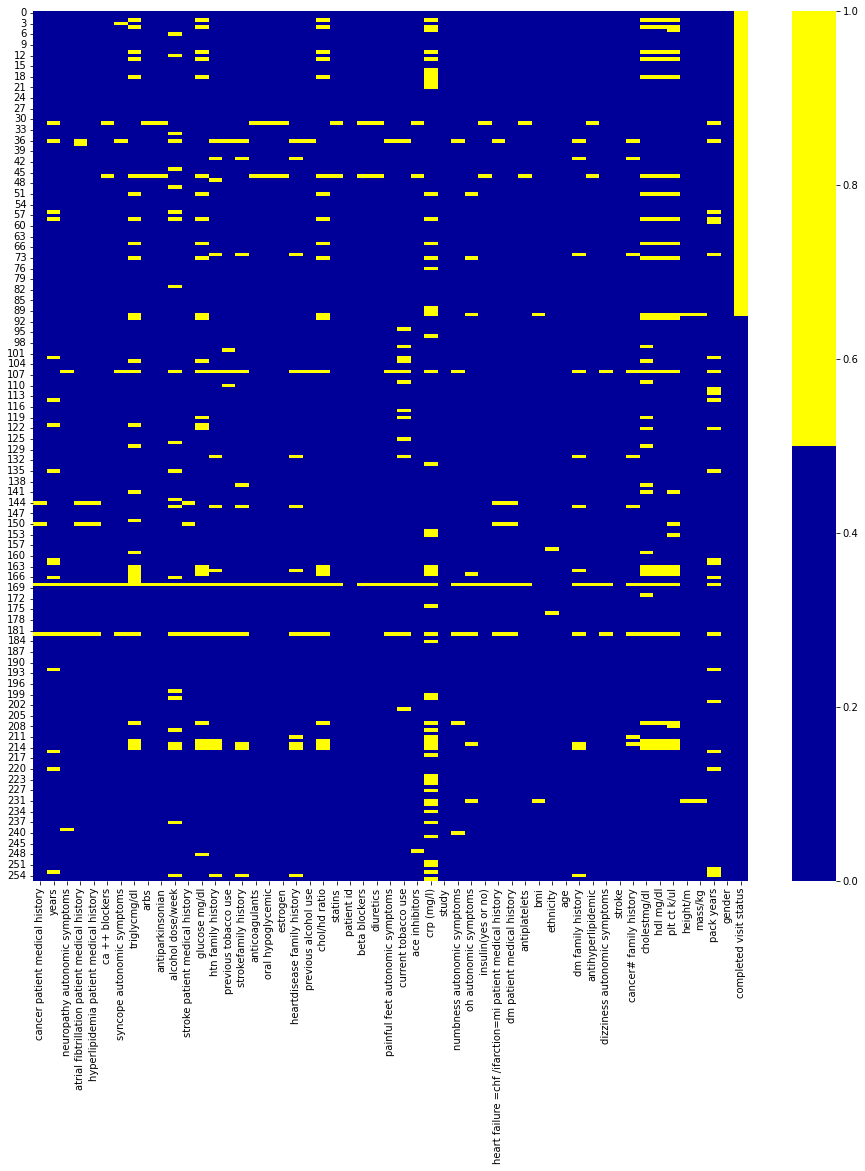

In [390]:
plt.figure(figsize = (16,16))
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(merged_v8.isna(), cmap=sns.color_palette(colours))

In [391]:
get_plot_na(merged_v8, 0)

completed visit status is expected to present a lot of missing value 

In [392]:
get_plot_na(merged_v8, 1)

Refine Filtering:
- bio measures are the one showing the most missing values
- drop ethnicity because only hispanic or non hispanic info
- drop the 2 patients with a missing bmi becaus same patients having a missing height and weight

In [393]:
merged_v9 = merged_v8.drop(['ethnicity', 'heart failure =chf /ifarction=mi patient medical history'], axis=1)
merged_v9 = merged_v9.dropna(subset = ['bmi', 'dm family history', 'strokefamily history'])

medication_features_v9 = merged_v9.columns[merged_v9.columns.isin(df_desc_v1[df_desc_v1["variable description"]=='medication classess']["patient id"])]
merged_v9 = merged_v9.dropna(subset = medication_features_v9)

<AxesSubplot:>

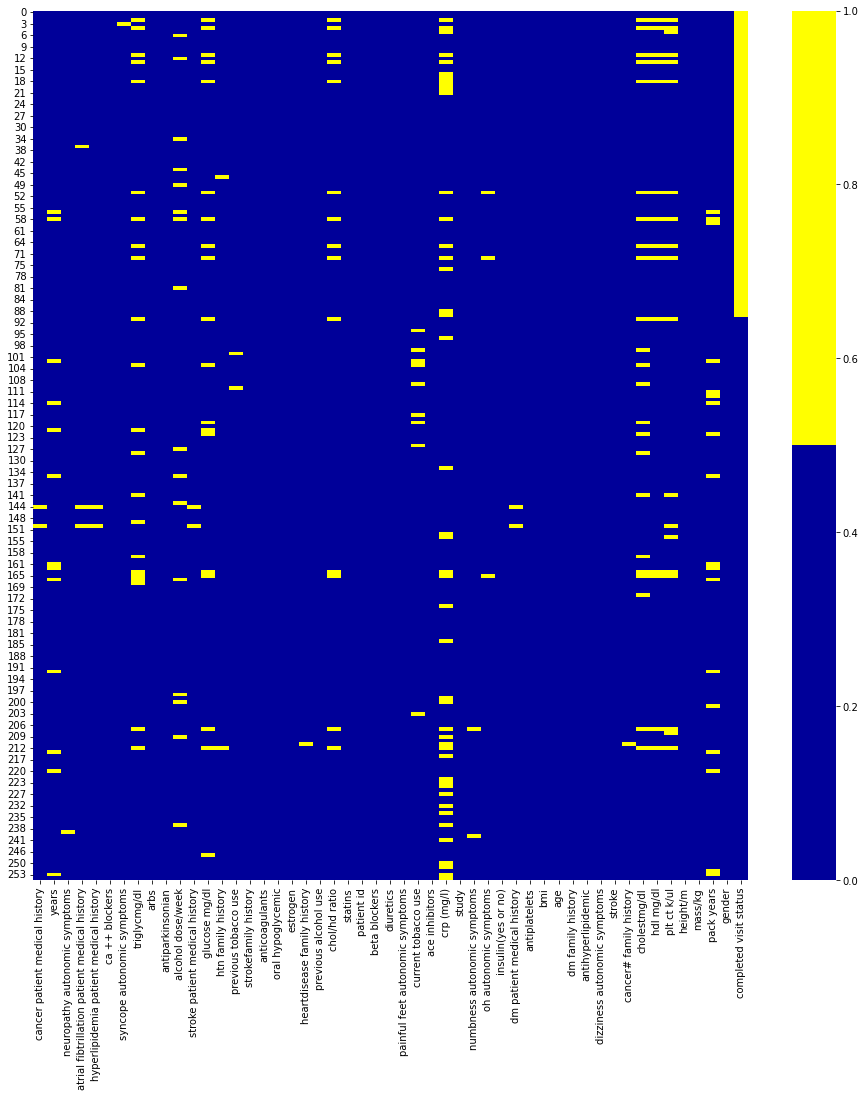

In [394]:
plt.figure(figsize = (16,16))
sns.heatmap(merged_v9.isna(), cmap=sns.color_palette(colours))

In [395]:
print(merged_v8.shape)
print(merged_v9.shape)

(245, 53)
(227, 51)


In [396]:
get_plot_na(merged_v9, 0)

In [397]:
get_plot_na(merged_v9, 1)

In [398]:
df_desc_v1[df_desc_v1["patient id"].isin(merged_v9.columns)]

,patient id,s0328,s0342,variable description,units
1,study,ge75,ge75,study number,NaN
5,age,50,76,age,years
8,bmi,27.6,23.6,body mass index,NaN
9,gender,m,m,sex ffemale mmale,NaN
14,previous tobacco use,no,no,previous tobacco use,NaN
15,current tobacco use,no,no,current tobacco use,NaN
17,years,0,0,years of smoking,NaN
18,previous alcohol use,yes,yes,previous alcohol use,NaN
20,alcohol dose/week,3,0,alcohol dose/week,NaN
21,neuropathy autonomic symptoms,no,no,neuropathy autonomic symptoms,NaN


In [399]:
print(f"Patients with dm medical history {(merged_v9['dm patient medical history']== YES_REPLACEMENT).sum()}")
print(f"Patients with stroke {(merged_v9['stroke'] == YES_REPLACEMENT).sum()}")
print(f"Patients with a past stroke  {(merged_v9['stroke patient medical history'] == YES_REPLACEMENT).sum()}")
print(f"Patients with stroke & DM {((merged_v9['stroke'] == YES_REPLACEMENT) & ('dm patient medical history'== YES_REPLACEMENT)).sum()}")

Patients with dm medical history 71
Patients with stroke 69
Patients with a past stroke  66
Patients with stroke & DM 0


## Exploration cognitive tests

In [400]:
cognitive_test_shared.append('patient id')

In [401]:
merged_cognitive_test_v9 = pd.merge(merged_v9,
                          pd.concat([df_stroke_homogenized[cognitive_test_shared], df_perfusion_homogenized[cognitive_test_shared]], axis=0),
                          on = "patient id")

In [402]:
merged_cognitive_test_v9.head()

,cancer patient medical history,years,neuropathy autonomic symptoms,atrial fibtrillation patient medical history,hyperlipidemia patient medical history,ca ++ blockers,syncope autonomic symptoms,triglycmg/dl,arbs,antiparkinsonian,alcohol dose/week,stroke patient medical history,glucose mg/dl,htn family history,previous tobacco use,strokefamily history,anticoagulants,oral hypoglycemic,estrogen,heartdisease family history,previous alcohol use,chol/hd ratio,statins,patient id,beta blockers,diuretics,painful feet autonomic symptoms,current tobacco use,ace inhibitors,crp (mg/l),study,numbness autonomic symptoms,oh autonomic symptoms,insulin(yes or no),dm patient medical history,antiplatelets,bmi,age,dm family history,antihyperlipidemic,dizziness autonomic symptoms,stroke,cancer# family history,cholestmg/dl,hdl mg/dl,plt ct k/ul,height/m,mass/kg,pack years,gender,completed visit status,rcft i.r. time (sec),cognitive handedness (r/l),rcft d.r. time (sec),ds scaled score,ds forward (items correct),tm part b time (sec),tm part a time (sec),vf # animals scaledscore,vf scaled score,rcft copy time (sec),ds backward (item number),tm scaled score
0,no,10.0,no,no,no,no,no,267.0,no,no,7.0,no,211.0,1.0,yes,0.0,no,yes,no,1.0,yes,4.5,no,s0250,no,no,no,no,no,0.240,cerebral_perfusion_diabetes,no,no,no,yes,no,35.782279,50,1.0,no,no,no,1.0,135.0,36.0,250.0,1.790,114.65,2.86,male,NaN,132.0,NaN,65.0,7.0,8.0,139.0,36.0,9.0,6.0,152.0,2.0,6.0
1,no,1.0,no,no,no,no,yes,95.0,no,no,0.5,no,95.0,1.0,yes,1.0,no,no,no,1.0,yes,3.0,no,s0254,no,no,no,no,no,0.104,cerebral_perfusion_diabetes,no,no,no,no,no,24.275148,69,0.0,no,no,no,1.0,176.0,59.0,242.0,1.531,56.90,0.14,female,NaN,63.0,NaN,28.0,8.0,9.0,104.0,39.0,10.0,10.0,216.0,2.0,8.0
2,no,0.0,no,no,yes,no,no,NaN,no,no,9.0,no,NaN,0.0,no,0.0,no,no,no,3.0,yes,NaN,yes,s0255,yes,no,no,no,no,NaN,cerebral_perfusion_diabetes,no,no,no,yes,no,28.466932,78,3.0,no,no,no,0.0,NaN,NaN,NaN,1.520,65.77,0.00,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yes,20.0,no,no,yes,no,NaN,111.0,no,no,3.0,no,111.0,0.0,yes,1.0,no,yes,no,1.0,yes,2.6,yes,s0256,no,no,no,no,no,0.060,cerebral_perfusion_diabetes,no,no,no,yes,yes,29.629630,65,3.0,no,no,no,2.0,194.0,75.0,315.0,1.575,73.50,5.71,female,NaN,74.0,NaN,NaN,14.0,10.0,50.0,30.0,16.0,18.0,116.0,6.0,12.0
4,no,0.0,no,no,no,no,no,NaN,no,no,0.0,no,NaN,1.0,no,1.0,no,no,no,1.0,no,NaN,no,s0257,no,no,no,no,no,NaN,cerebral_perfusion_diabetes,no,no,no,no,no,24.328720,55,0.0,no,no,no,0.0,NaN,NaN,NaN,1.700,70.31,0.00,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [403]:
get_plot_na(merged_cognitive_test_v9, axis=0).show()

In [404]:
get_plot_na(merged_cognitive_test_v9[merged_cognitive_test_v9["study"]=="cerebral_elderly_stroke"],
            axis=0)

In [405]:
get_plot_na(merged_cognitive_test_v9[merged_cognitive_test_v9["study"]=="cerebral_perfusion_diabetes"],
            axis=0)

It is impossible to filter all the na value and keep enough patients/features.
The next step is to save the version of the data and analyze them.

In [406]:
#merged_v9.to_csv('../data/merging/merged_v1.csv' , index=False, header=True)
merged_v9.to_csv('../data/merging/merged_v2.csv' , index=False, header=True)